In [157]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing_extensions import Literal
from sklearn.feature_extraction.text import CountVectorizer
from dataclasses import dataclass
from abc import abstractmethod
import nltk
from nltk.tokenize import word_tokenize
import string
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from tqdm import tqdm

In [35]:
class TextPreprocesser():
    def __init__(
        self,
    ):
        pass
    
    def __call__(self, corpus: pd.Series):
        corpus = corpus.str.lower()
        res_corpus = []
        for i, row in corpus.items():
            words = nltk.word_tokenize(row)
            res_corpus.append([word for word in words if word not in string.punctuation])
        
        return pd.Series(res_corpus)

In [36]:
class Vectorizer():
    @abstractmethod
    def fit(self):
        pass

    @abstractmethod
    def transform(self):
        pass
    
    @abstractmethod
    def get_vocab_size(self):
        pass


class IndexVectorizer(Vectorizer):
    def __init__(self):
        self.vocab = dict()
        self.vocab['<PAD>'] = 0
        
    def fit(self, corpus):
        cnt = len(self.vocab)
        for row in corpus:
            for word in row:
                if word not in self.vocab:
                    self.vocab[word] = cnt
                    cnt += 1

    def transform(self, corpus):
        res = []
        for row in corpus:
            cur = []
            for word in row:
                if word in self.vocab:
                    cur.append(self.vocab[word])
                else:
                    cur.append(0)
            res.append(cur)
        return pd.Series(res)
    
    def get_vocab_size(self):
        return len(self.vocab)
        


class CountVectorizer(Vectorizer): 
    def __init__(self):
        self.vectorizer = CountVectorizer()

    def fit(self, df, column_w_features):
        self.vectorizer.fit(df.loc[:, column_w_features].str)
        
    def transform(self, df, column_w_features):
        return self.vectorizer.transform(df.loc[:, column_w_features])

In [97]:
class InputDataPipeline():
    def __init__(
        self,
        text_preprocesser: TextPreprocesser,
        vectorizer: Vectorizer,
        max_seq_length: int = None
    ):
        self.text_preprocesser = text_preprocesser
        self.vectorizer = vectorizer
        self.max_seq_length = max_seq_length
        
    def __set_max_seq_length(self, splitted: pd.Series):
        if self.max_seq_length is None:
            self.max_seq_length = splitted.apply(len).max()
            
    def get_vocab_size(self):
        return self.vectorizer.get_vocab_size()
    
    def get_max_seq_length(self):
        return self.max_seq_length
        
    def fit(self, corpus: pd.Series) -> None:
        preprocessed = self.text_preprocesser(corpus)
        self.__set_max_seq_length(preprocessed)
        self.vectorizer.fit(preprocessed)

    def transform(self, corpus) -> torch.tensor:
        corpus = self.text_preprocesser(corpus)
        corpus.apply(lambda x: x[:self.max_seq_length])
        corpus = self.vectorizer.transform(corpus)
        corpus = corpus.apply(lambda x: torch.tensor(x))
        corpus = pad_sequence(corpus, batch_first=True, padding_value=0)
        
        return torch.tensor(corpus)
    
    def fit_transform(self, corpus) -> torch.tensor:
        self.fit(corpus)
        return self.transform(corpus)

In [98]:
df = pd.read_csv('data/train.tsv', delimiter='\t')
df['Phrase'] = df['Phrase'].astype('string')
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [99]:
pipe = InputDataPipeline(
    text_preprocesser=TextPreprocesser(),
    vectorizer=IndexVectorizer()
)
pipe.fit(df.loc[:, 'Phrase'])

In [100]:
class SentimentDataset(Dataset):
    def __init__(
        self, 
        path: str,
        input_data_pipeline: InputDataPipeline,
        text_column: str,
        label_column: str = None,
        delimeter='\t'
    ):
        self.X = None
        self.y = None
        self.text_column = text_column
        self.label_column = label_column
        self.input_data_pipeline = input_data_pipeline
        
        
        self.__prepare_input_df(
            pd.read_csv(path, delimiter=delimeter)
        )

    def __prepare_input_df(self, df):
        df[self.text_column] = df[self.text_column].astype('string')
        df[self.text_column] = df[self.text_column].replace({None: 'None'})
        self.X = self.input_data_pipeline.transform(df.loc[:, self.text_column])
        if self.label_column is not None:
            self.y = torch.tensor(df.loc[:, self.label_column])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        if self.label_column is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [101]:
TRAIN_SIZE = 0.9

input_train_dataset = SentimentDataset(
    path='data/train.tsv',
    input_data_pipeline=pipe,
    text_column='Phrase',
    label_column='Sentiment'
)
test_dataset = SentimentDataset(
    path='data/test.tsv',
    input_data_pipeline=pipe,
    text_column='Phrase',
)

train_size = int(TRAIN_SIZE * len(input_train_dataset))
val_size = len(input_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    input_train_dataset, [train_size, val_size]
)

/tmp/ipykernel_34133/3693921853.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(corpus)
/tmp/ipykernel_34133/3693921853.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(corpus)


In [102]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [103]:
VOCAB_SIZE = pipe.get_vocab_size()
VOCAB_SIZE

16523

In [168]:
model_config = {
    'max_seq_length': pipe.get_max_seq_length(),
    'embed_size': 200,
    'hidden_layer_1_size': 400,
    'target_size': 5
}
model_config

{'max_seq_length': 49,
 'embed_size': 200,
 'hidden_layer_1_size': 400,
 'target_size': 5}

In [180]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        g = torch.Generator().manual_seed(78)
        self.config = config
        self.C = nn.Parameter(torch.rand((VOCAB_SIZE, model_config['embed_size']), generator=g), requires_grad=True)
        self.input_dim = self.config['max_seq_length'] * self.config['embed_size']
        self.W1 = nn.Parameter(torch.rand(self.input_dim, model_config['hidden_layer_1_size']), requires_grad=True)
        self.b1 = nn.Parameter(torch.rand(model_config['hidden_layer_1_size']), requires_grad=True)
        self.W2 = nn.Parameter(torch.rand((model_config['hidden_layer_1_size'], model_config['target_size'])), requires_grad=True)
        self.b2 = nn.Parameter(torch.rand(model_config['target_size']), requires_grad=True)
        self.softmax = nn.Softmax()

        
    def forward(self, Xtr):
        # print(f'Xtr shape = {Xtr.shape}')
        embeds = self.C[Xtr]
        # print(f'embeds shape = {embeds.shape}')
        cur_batch_size = embeds.shape[0]
        viewed = embeds.view(cur_batch_size, -1)
        # print(f'viewed shape = {viewed.shape}')
        h = torch.tanh(viewed @ self.W1 + self.b1)
        # print(f'h shape = {h.shape}')
        logits = h @ self.W2 + self.b2
        # print(f'logits shape = {logits.shape}')
        out = self.softmax(logits)
        return out

In [181]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(model_config).to(device)
print(model)

MLP(
  (softmax): Softmax(dim=None)
)


In [182]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = input_data
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        # print(f'output shape = {output.shape}')
        # print(f'y shape = {y.shape}')
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        if batch_num % 1000 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
            
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

/home/denis/.pyenv/versions/3.12.1/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


	Epoch 0 | Batch 0 | Loss   1.76
	Epoch 0 | Batch 1000 | Loss   1.40
	Epoch 0 | Batch 2000 | Loss   1.40
	Epoch 0 | Batch 3000 | Loss   1.28
	Epoch 0 | Batch 4000 | Loss   1.50
Epoch 0 | Loss   1.40
	Epoch 1 | Batch 0 | Loss   1.31
	Epoch 1 | Batch 1000 | Loss   1.28
	Epoch 1 | Batch 2000 | Loss   1.44
	Epoch 1 | Batch 3000 | Loss   1.28
	Epoch 1 | Batch 4000 | Loss   1.44
Epoch 1 | Loss   1.40
	Epoch 2 | Batch 0 | Loss   1.31
	Epoch 2 | Batch 1000 | Loss   1.40
	Epoch 2 | Batch 2000 | Loss   1.34
	Epoch 2 | Batch 3000 | Loss   1.22
	Epoch 2 | Batch 4000 | Loss   1.50
Epoch 2 | Loss   1.40
	Epoch 3 | Batch 0 | Loss   1.34
	Epoch 3 | Batch 1000 | Loss   1.44
	Epoch 3 | Batch 2000 | Loss   1.40
	Epoch 3 | Batch 3000 | Loss   1.59
	Epoch 3 | Batch 4000 | Loss   1.28
Epoch 3 | Loss   1.40
	Epoch 4 | Batch 0 | Loss   1.37
	Epoch 4 | Batch 1000 | Loss   1.47
	Epoch 4 | Batch 2000 | Loss   1.40
	Epoch 4 | Batch 3000 | Loss   1.50
	Epoch 4 | Batch 4000 | Loss   1.31
Epoch 4 | Loss   1.40
	Epoc

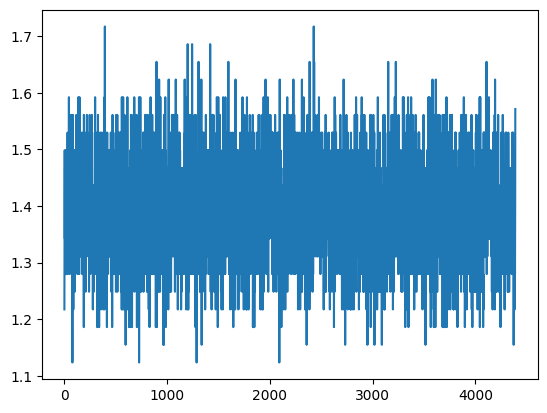

In [177]:
plt.plot(np.arange(len(losses)), losses)